Notebook to compare mean outgoing longwave radiation at toa from NextGEMS simulations (using Low Resolution Archive) with CERES (observations of radiation)

In [2]:
import matplotlib.pyplot as plt
from aqua import Reader

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-monthly	LRA data monthly at r100
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y
IFS	tco25

In case you want to run notebook with slurm

In [ ]:
from aqua.slurm import slurm
slurm.job(cores=8, memory="50 GB", jobs=1, queue = "interactive", walltime='00:30:00')

2023-06-06 16:54:05 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-06-06 16:54:05 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-06-06 16:54:05 :: create_folder :: WARNING  -> Folder ./slurm/output already exists
2023-06-06 16:54:15 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p interactive
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=47G
#SBATCH -t 00:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382216/mambaforge/envs/aqua/bin/python -m distributed.cli.dask_worker tcp://136.172.124.6:36805 --nthreads 2 --nworkers 4 --memory-limit 11.64GiB --name dummy-name --nanny --death-timeout 60



In [ ]:
slurm.squeue()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           5231577 interacti dask-wor  b382216  R       0:05      1 l40049


0

Explore the CERES catalogue (CERES is used as reference to compare models)

In [3]:
reader = Reader(model="CERES", exp="ebaf-toa42", source="monthly")
data = reader.retrieve(fix=False, var="toa_lw_all_mon")
data

<xarray.Dataset>
Dimensions:         (time: 275, lat: 180, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2000-03-15 2000-04-15 ... 2023-01-15
  * lon             (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    toa_lw_all_mon  (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Release Date December 9, 2022
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF-TOA_L3B004.2
    Fill_Value:   Fill Value is -999.0
    history:      Tue May 02 12:30:56 2023: cdo -selname,cldarea_total_daynig...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [4]:
reader = Reader(model="CERES", exp="ebaf-toa42", source="monthly", regrid="r100")
data = reader.retrieve(var="toa_lw_all_mon")
data_avrg = reader.fldmean(data["toa_lw_all_mon"])


2023-06-06 16:54:40 :: Reader :: WARNING  -> No variables in the fixes for source monthly
2023-06-06 16:54:40 :: Reader :: WARNING  -> Returning the original variable


Now load NextGems data from LRA and observations (CERES) for net LW radiation at TOA

2023-06-06 17:06:58 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly
2023-06-06 17:06:59 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source lra-r100-monthly


Text(0.5, 1.0, 'global mean top net thermal radiation flux')

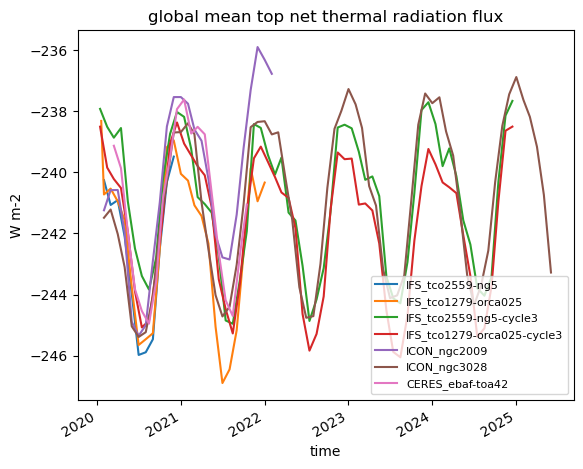

In [7]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025", "tco2559-ng5-cycle3", "tco1279-orca025-cycle3"], "ICON": ["ngc2009", "ngc3026","ngc3028"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-monthly"], "ICON": ["lra-r100-monthly"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve(fix=False, var="toa_lw_all_mon") 
                data[(model, exp)] = reader.fldmean(data[(model, exp)]["toa_lw_all_mon"][240:260]*-1)
            else:
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve(fix=False, var="mtntrf") 
                data[(model, exp)] = reader.fldmean(data[(model, exp)]["mtntrf"])


plt.figure(figsize=(12, 6))
for model in model_list:
    for exp in exp_name[model]:
        data[(model, exp)].plot(label=f"{model}_{exp}")
plt.legend(fontsize=8)
plt.ylabel("W m-2")
plt.title("global mean top net thermal radiation flux")

Same but for SW radiation

2023-06-06 17:07:42 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly
2023-06-06 17:07:44 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source lra-r100-monthly


Text(0.5, 1.0, 'global mean top net solar radiation flux')

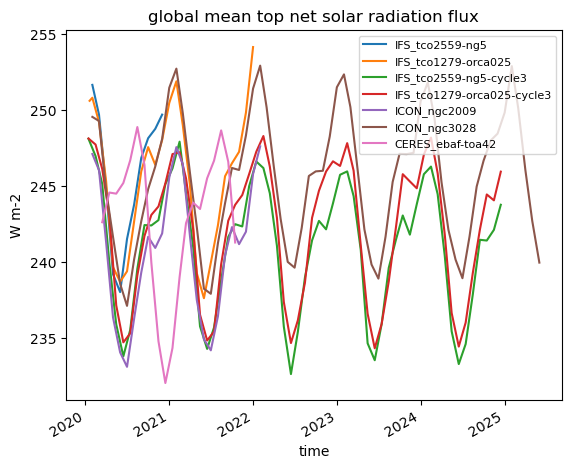

In [8]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025", "tco2559-ng5-cycle3", "tco1279-orca025-cycle3"], "ICON": ["ngc2009", "ngc3026", "ngc3028"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-monthly"], "ICON": ["lra-r100-monthly"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve(fix=False)["toa_sw_all_mon"]
                data[(model, exp)] = - reader.fldmean(data[(model, exp)][240:260]) +340
            else:
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["mtnsrf"]
                data[(model, exp)]= reader.fldmean(data[(model, exp)])

plt.figure(figsize=(12, 6))
for model in model_list:
    for exp in exp_name[model]:
        data[(model, exp)].plot(label=f"{model}_{exp}")
plt.legend(fontsize=8)
plt.ylabel("W m-2")
plt.title("global mean top net solar radiation flux")

Now plot net radiation at TOA (SW-LW)

2023-05-31 18:25:22 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly
2023-05-31 18:25:23 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source lra-r100-monthly


Text(0.5, 1.0, 'global mean net radiation flux at toa')

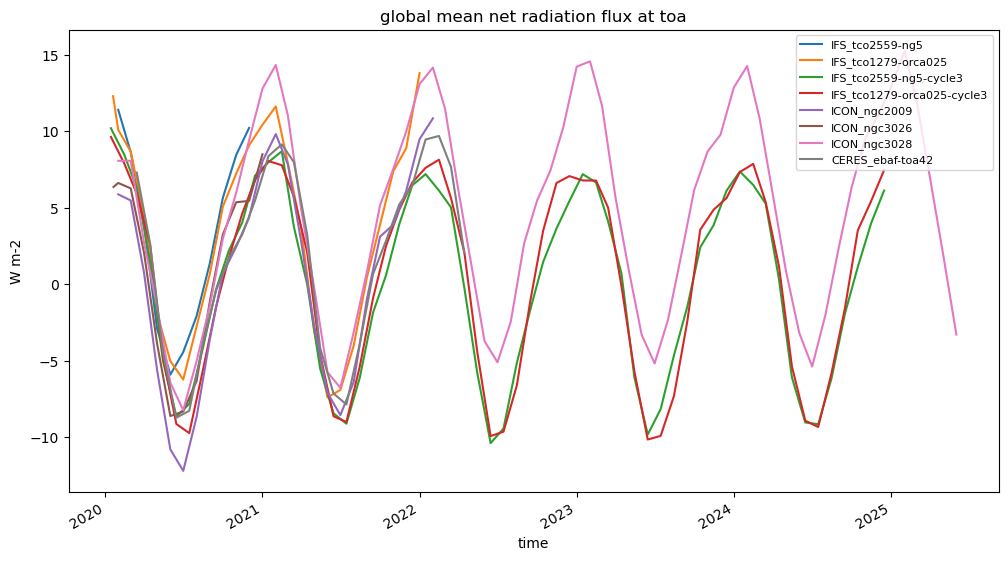

In [8]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025", "tco2559-ng5-cycle3", "tco1279-orca025-cycle3"], "ICON": ["ngc2009", "ngc3026", "ngc3028"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-monthly"], "ICON": ["lra-r100-monthly"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["toa_net_all_mon"]
                data[(model, exp)] = reader.fldmean(data[(model, exp)][240:266])
            else:
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["mtnsrf"] + reader.retrieve()["mtntrf"]
                data[(model, exp)]= reader.fldmean(data[(model, exp)])

plt.figure(figsize=(12, 6))
for model in model_list:
    for exp in exp_name[model]:
        data[(model, exp)].plot(label=f"{model}_{exp}")
plt.legend(fontsize=8)
plt.ylabel("W m-2")
plt.title("global mean net radiation flux at toa")